In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#all the imports
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn.model_selection import train_test_split
import xgboost as xgb


## The purpose of this case is to predict the value of target_flag, which is a binary value that indicates whether the insured person asked for redeeming.

##We will use the data set train_auto to train and evaluate our model, then we will use the obtained model to give predictions for the test_auto data set.

## I chose to use google colab in order to use GPU in finetuning the model's hyperparameters.

In [49]:


df_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/train_auto.csv')

df_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/test_auto.csv')

In [50]:
df_train.shape, df_test.shape

((8161, 26), (2141, 26))

In [51]:
print(" \nCount total NaN at each column in the training dataset : \n\n") 


msno.matrix(df_train)

 
Count total NaN at each column in the training dataset : 




 
Count total NaN at each column in the test data frame: 




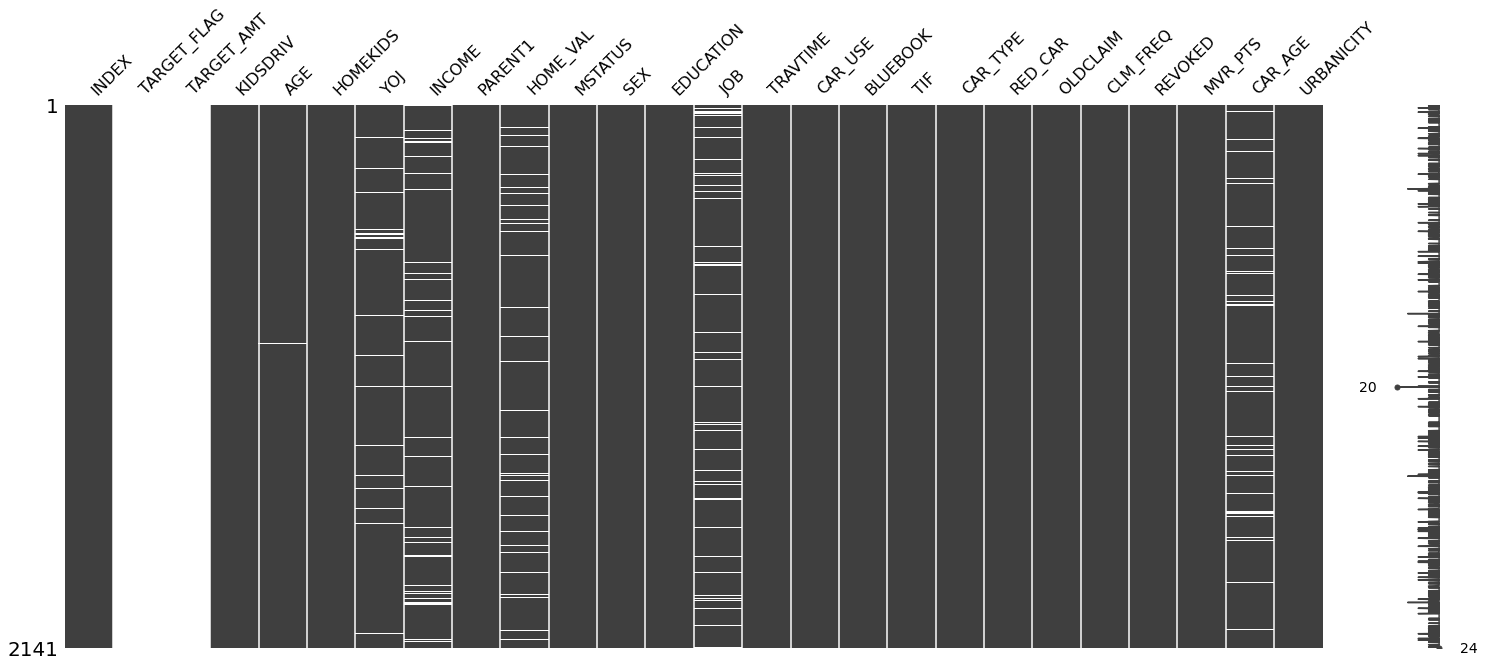

In [52]:
print(" \nCount total NaN at each column in the test data frame: \n\n") 


msno.matrix(df_test)

In [53]:

sns.distplot(df_train['AGE'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [54]:
# plot of the dataset in terms of the educational level of the insured person


fig = plt.figure(1, figsize=(14, 15))

num_phd = len(df_train[df_train['EDUCATION'] =='PhD'])

num_z_High_School = len(df_train[df_train['EDUCATION'] =='z_High School'])

num_High_School = len(df_train[df_train['EDUCATION'] =='<High School'])

num_Bachelors = len(df_train[df_train['EDUCATION'] =='Bachelors'])

num_Masters = len(df_train[df_train['EDUCATION'] =='Masters'])

num_none_lucky = len(df_train[df_train['EDUCATION'].isnull()])


df = pd.DataFrame({'lab':['PhD', 'z_High School', '<High School', 'Bachelors', 'Masters', 'None'],
                   'val':[num_phd, num_z_High_School, num_High_School, num_Bachelors, num_Masters, num_none_lucky]})
ax = df.plot.bar(x='lab', y='val', rot=0)

<Figure size 1008x1080 with 0 Axes>

## This function performs data formating over the data set (both training and test data sets). It formats money amounts in float values, and encodes categorical values in numerical format. It also removes some outlyers (negative car ages for instance)

In [55]:

def edit_data(df):
  df['INCOME'] = df['INCOME'].str.replace(',', '')
  df['INCOME'] = df['INCOME'].str.replace('$', '')
  df['INCOME'] = df['INCOME'].astype(float) 

  df['HOME_VAL'] = df['HOME_VAL'].str.replace(',', '')
  df['HOME_VAL'] = df['HOME_VAL'].str.replace('$', '')
  df['HOME_VAL'] = df['HOME_VAL'].astype(float) 

  df['BLUEBOOK'] = df['BLUEBOOK'].str.replace(',', '')
  df['BLUEBOOK'] = df['BLUEBOOK'].str.replace('$', '')
  df['BLUEBOOK'] = df['BLUEBOOK'].astype(float) 

  df['OLDCLAIM'] = df['OLDCLAIM'].str.replace(',', '')
  df['OLDCLAIM'] = df['OLDCLAIM'].str.replace('$', '')
  df['OLDCLAIM'] = df['OLDCLAIM'].astype(float) 

  df = pd.get_dummies(df, columns=['PARENT1'])
  df = pd.get_dummies(df, columns=['MSTATUS'])
  df = pd.get_dummies(df, columns=['SEX'])
  df = pd.get_dummies(df, columns=['EDUCATION'])
  df = pd.get_dummies(df, columns=['JOB'])
  df = pd.get_dummies(df, columns=['CAR_USE'])
  df = pd.get_dummies(df, columns=['CAR_TYPE'])
  df = pd.get_dummies(df, columns=['RED_CAR'])
  df = pd.get_dummies(df, columns=['URBANICITY'])
  df = pd.get_dummies(df, columns=['REVOKED'])

  #df = df[df['CAR_AGE']>=0]
  return(df)

df = pd.concat([df_train, df_test])
df =df.set_index('INDEX')

df = edit_data(df)

min_max_scaler = preprocessing.MinMaxScaler()

df[['INCOME','HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']] = min_max_scaler.fit_transform(df[['INCOME','HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']])



df_train = df[df.index.isin(df_train['INDEX'].values)]

df_test =  df[df.index.isin(df_test['INDEX'].values)]


## Let's check whether our data set target is unbalanced.

In [56]:

fig = plt.figure(1, figsize=(14, 15))

num_0= len(df_train[df_train['TARGET_FLAG'] ==0])

num_1 = len(df_train[df_train['TARGET_FLAG'] ==1])


df = pd.DataFrame({'lab':['TARGET_FLAG 0', 'TARGET_FLAG 1'],
                   'val':[num_0, num_1]})
ax = df.plot.bar(x='lab', y='val', rot=0)

<Figure size 1008x1080 with 0 Axes>

## It's unbalanced indeed, we have few positives, we should take this in consideration  when performing our model.

In [57]:


sns.distplot(df_train['CAR_AGE'])

df_train[df_train['AGE']<0]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Empty DataFrame
Columns: [TARGET_FLAG, TARGET_AMT, KIDSDRIV, AGE, HOMEKIDS, YOJ, INCOME, HOME_VAL, TRAVTIME, BLUEBOOK, TIF, OLDCLAIM, CLM_FREQ, MVR_PTS, CAR_AGE, PARENT1_No, PARENT1_Yes, MSTATUS_Yes, MSTATUS_z_No, SEX_M, SEX_z_F, EDUCATION_<High School, EDUCATION_Bachelors, EDUCATION_Masters, EDUCATION_PhD, EDUCATION_z_High School, JOB_Clerical, JOB_Doctor, JOB_Home Maker, JOB_Lawyer, JOB_Manager, JOB_Professional, JOB_Student, JOB_z_Blue Collar, CAR_USE_Commercial, CAR_USE_Private, CAR_TYPE_Minivan, CAR_TYPE_Panel Truck, CAR_TYPE_Pickup, CAR_TYPE_Sports Car, CAR_TYPE_Van, CAR_TYPE_z_SUV, RED_CAR_no, RED_CAR_yes, URBANICITY_Highly Urban/ Urban, URBANICITY_z_Highly Rural/ Rural, REVOKED_No, REVOKED_Yes]
Index: []

## Here comes the training step, we will split our labeled data into train and test datasets.

In [58]:
X_train

array([[ 0., 42.,  0., ...,  0.,  1.,  0.],
       [ 0., 28.,  3., ...,  1.,  1.,  0.],
       [ 1., 36.,  2., ...,  1.,  1.,  0.],
       ...,
       [ 0., 46.,  0., ...,  0.,  0.,  1.],
       [ 0., 43.,  1., ...,  1.,  1.,  0.],
       [ 0., 42.,  2., ...,  0.,  0.,  1.]], dtype=float32)

In [59]:
#we define the features matric and the target matrix


X_train, X_test, y_train, y_test = train_test_split(df_train[df_train.columns[2:]].values, df_train['TARGET_FLAG'].values, test_size = 0.1, random_state = 0)

X_train = np.asarray(X_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)


In [60]:

#to insure that we have a GPU device
tf.test.gpu_device_name()

''

## We will use the XGboost classifier model, which is a very performant model in terms of computation time. It also deals with missing data which is very good.

## We will finetune the model using Google GPU.

## To assess our model's learning we will use the accuracy and AUC metrics.



In [62]:
# create a default XGBoost classifier

#tree_method = "gpu_hist",
model = XGBClassifier(tree_method = "gpu_hist",
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}


scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 1.83 s, sys: 10.5 ms, total: 1.84 s
Wall time: 14.5 s


In [63]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.8235168305394129
Best model: {'subsample': 0.8, 'reg_lambda': 1.5, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


### In order to evaluate our model's performance, we ought to draw the confusion matrix as well as the classification reports. We compute the train and test accuracy as well.

Train Accuracy:  0.8163126361655774
Test Accuraccy:  0.8102815177478581

Confusion Matrix:
[[552  59]
 [ 96 110]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.88       611
         1.0       0.65      0.53      0.59       206

    accuracy                           0.81       817
   macro avg       0.75      0.72      0.73       817
weighted avg       0.80      0.81      0.80       817



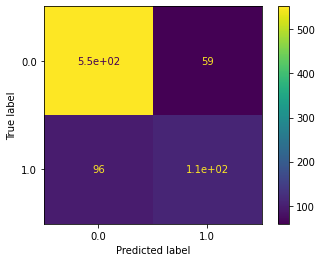

In [64]:

pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

plot_confusion_matrix( best_model, X_test, y_test)  

## As we can notice, our model performs very well in terms of test accuracy (80%), but does badly when it comes to minimizing false negatives. That must be due to the fact that the negative class is **under-represented**. 

## In order to minimize the number of false negatives (minimize the risk), we need to use approaches that resist to the fact that our dataset target is unbalanced.

## for that we will use cost sensitive learning: we give weights to our training samples in function of their target class.

In [65]:
# create a default XGBoost classifier

class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[int(val)]

#tree_method = "gpu_hist",
model = XGBClassifier(tree_method = "gpu_hist",
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}


scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model_weighted = grid.fit(X_train,y_train, sample_weight= w_array)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


CPU times: user 2.39 s, sys: 13.5 ms, total: 2.41 s
Wall time: 18.6 s


In [66]:
print(f'Best score: {best_model_weighted.best_score_}')
print(f'Best model: {best_model_weighted.best_params_}')

Best score: 0.8231949119172978
Best model: {'subsample': 0.8, 'reg_lambda': 1.5, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [67]:

pred_test = best_model_weighted.predict(X_test)
pred_train = best_model_weighted.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

plot_confusion_matrix(best_model_weighted, X_test, y_test)  

Train Accuracy:  0.7706971677559913
Test Accuraccy:  0.7258261933904528

Confusion Matrix:
[[437 174]
 [ 50 156]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80       611
         1.0       0.47      0.76      0.58       206

    accuracy                           0.73       817
   macro avg       0.69      0.74      0.69       817
weighted avg       0.79      0.73      0.74       817



## We conclude that using the cost sensitive learning we have a lower accuracy for both test and training. Nevertheless, we have way less false negatives!

## Here we can evaluate the features importance.

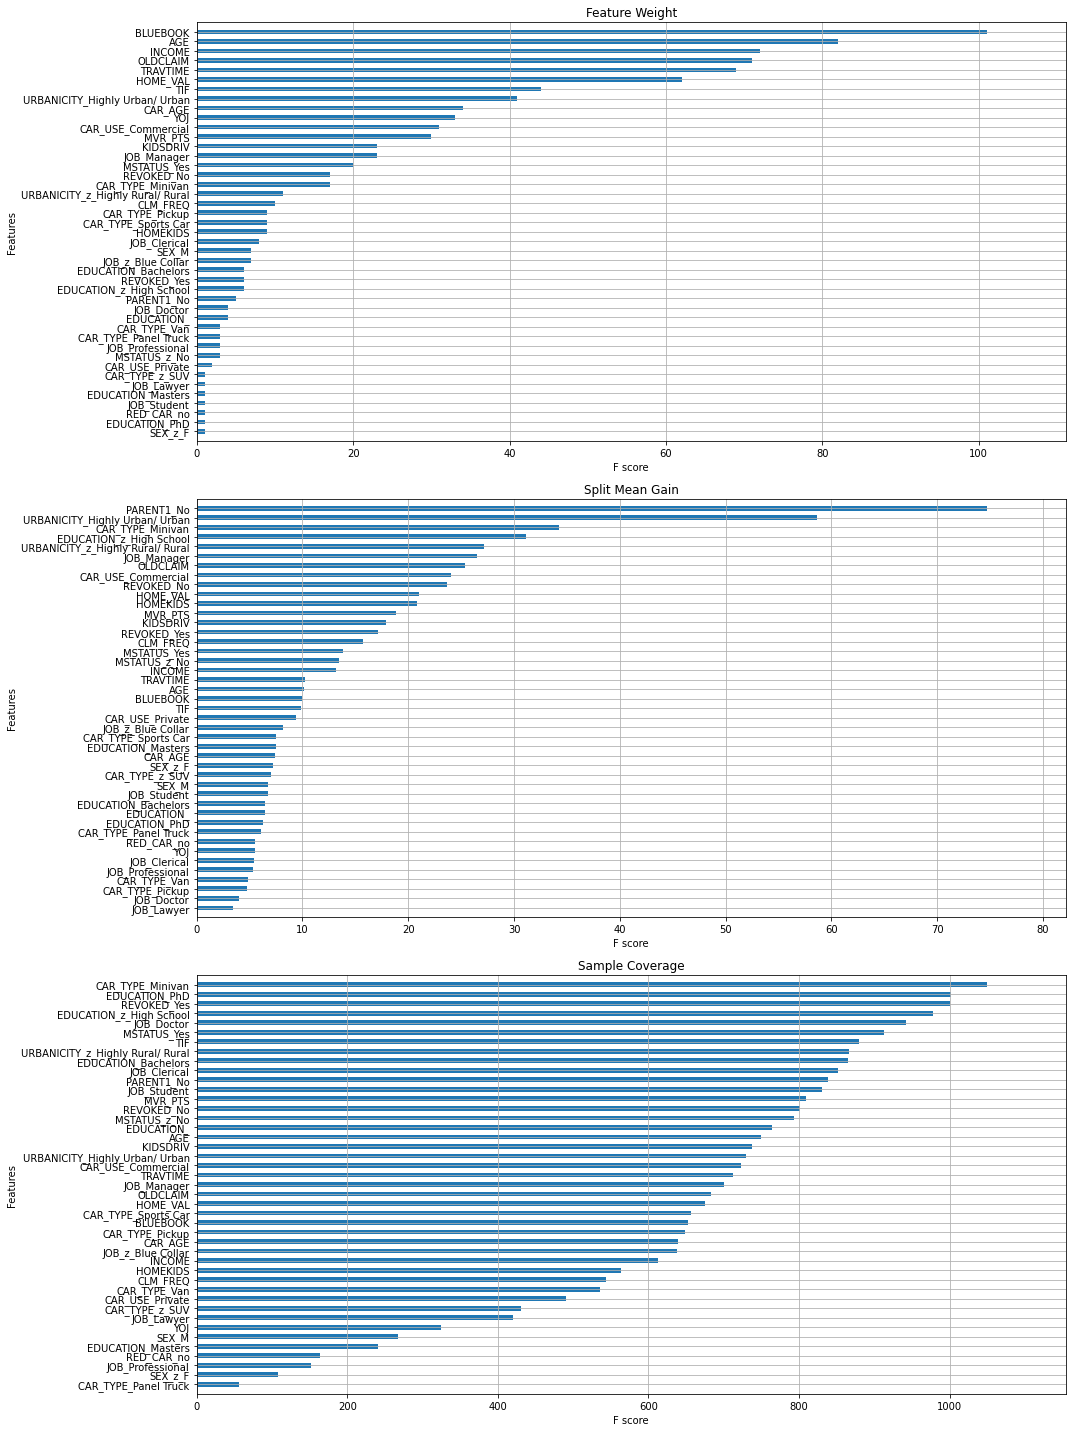

In [23]:
# store the winning model in a new variable
xgc = best_model_weighted.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = df_train.columns[2:].to_list()
# Create the feature importances plot
fig, ax = plt.subplots(3, 1, figsize=(15,20))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

## Now let's use the classifier to predict the target values of the test data set df_test (test_auto)

In [68]:
#we predict the values for the 'target_flag' column of df_test
predictions = best_model_weighted.predict(np.asarray(df_test[df_test.columns[2:]].values).astype(np.float32))
predictions 

array([0., 1., 0., ..., 0., 0., 0.])

In [69]:
len(predictions) , df_test.shape

(2141, (2141, 48))

In [70]:
df_test['TARGET_FLAG'] = predictions
df_test.head()

TARGET_FLAG  TARGET_AMT  ...  REVOKED_No  REVOKED_Yes
INDEX                           ...                         
3              0.0         NaN  ...           1            0
9              1.0         NaN  ...           1            0
10             0.0         NaN  ...           1            0
18             0.0         NaN  ...           0            1
21             0.0         NaN  ...           1            0

[5 rows x 48 columns]

In [71]:
#the ratio of insured people who will ask for redeeming
np.sum(df_test['TARGET_FLAG']) / len(df_test['TARGET_FLAG'])

0.41289117234936945

## Here we store the df_test filled with predicted target_flag filled

In [72]:
# store the. df_test filled

df_test_filled = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/test_auto.csv')

df_test_filled['TARGET_FLAG'] = predictions

df_test_filled.to_csv(r'/content/drive/My Drive/Colab Notebooks/descartes_test_filled.csv', index = False, header=True)
